# CNNによる細胞セグメンテーション

## モデルの定義

In [1]:
import chainer
import chainer.functions as F
import chainer.links as L

class SegmentationModel(chainer.Chain):

    def __init__(self, n_class=2):
        super().__init__()
        with self.init_scope():
            # L.Convolution2D(in_ch, out_ch, ksize, stride, pad)
            # L.Deconvolution2D(in_ch, out_ch, ksize, stride, pad)

            self.conv1_1 = L.Convolution2D(None, 16, ksize=3, stride=1, pad=1)
            self.conv1_2 = L.Convolution2D(None, 16, ksize=3, stride=1, pad=1)
            self.conv2_1 = L.Convolution2D(None, 32, ksize=3, stride=1, pad=1)
            self.conv2_2 = L.Convolution2D(None, 32, ksize=3, stride=1, pad=1)
            self.conv3_1 = L.Convolution2D(None, 64, ksize=3, stride=1, pad=1)
            self.conv3_2 = L.Convolution2D(None, 64, ksize=3, stride=1, pad=1)
            self.conv4_1 = L.Convolution2D(None, 32, ksize=3, stride=1, pad=1)
            self.conv4_2 = L.Convolution2D(None, 32, ksize=3, stride=1, pad=1)
            self.conv5_1 = L.Convolution2D(None, 16, ksize=3, stride=1, pad=1)
            self.conv5_2 = L.Convolution2D(None, 16, ksize=3, stride=1, pad=1)
            self.conv6 = L.Convolution2D(None, n_class, ksize=1, stride=1, pad=0)

            self.dconv1 = L.Deconvolution2D(None, 32, ksize=2, stride=2, pad=0)
            self.dconv2 = L.Deconvolution2D(None, 16, ksize=2, stride=2, pad=0)

            self.bn1_1 = L.BatchNormalization(16)
            self.bn1_2 = L.BatchNormalization(16)
            self.bn2_1 = L.BatchNormalization(32)
            self.bn2_2 = L.BatchNormalization(32)
            self.bn3_1 = L.BatchNormalization(64)
            self.bn3_2 = L.BatchNormalization(64)
            self.bn4_1 = L.BatchNormalization(32)
            self.bn4_2 = L.BatchNormalization(32)
            self.bn5_1 = L.BatchNormalization(16)
            self.bn5_2 = L.BatchNormalization(16)

    def __call__(self, x):
        e1 = F.relu(self.bn1_1(self.conv1_1(x)))
        e2 = F.relu(self.bn1_2(self.conv1_2(e1)))
        del e1
        e3 = F.max_pooling_2d(e2, 2, 2)
        e4 = F.relu(self.bn2_1(self.conv2_1(e3)))
        e5 = F.relu(self.bn2_2(self.conv2_2(e4)))
        del e3, e4
        e6 = F.max_pooling_2d(e5, 2, 2)
        e7 = F.relu(self.bn3_1(self.conv3_1(e6)))
        e8 = F.relu(self.bn3_2(self.conv3_2(e7)))
        del e6, e7
        d1 = F.concat([self.dconv1(e8), e5])
        del e5, e8
        d2 = F.relu(self.bn4_1(self.conv4_1(d1)))
        d3 = F.relu(self.bn4_2(self.conv4_2(d2)))
        del d1, d2
        d4 = F.concat([self.dconv2(d3), e2])
        del e2, d3
        d5 = F.relu(self.bn5_1(self.conv5_1(d4)))
        d6 = F.relu(self.bn5_2(self.conv5_2(d5)))
        del d4, d5
        d7 = self.conv6(d6)
        del d6
        return d7

## 目的関数の定義

分類問題のときと同様に、Softmax Cross Entropy 関数を目的関数とする。


## 評価

一般的に、セグメンテーションの精度は**Pixel accuracy**や、**Mean Intersection over Union (mIoU)**といった指標で評価される。  
正解クラスが$i$であるピクセルをCNNモデルがクラス$j$に分類した数を$N_{ij}$とすると、クラス数が$k$のとき、Pixel AccuracyとmIoUは以下のようになる。

$$
{\rm Pixel\ Accuracy} = \frac{\sum_{i=1}^k N_{ii}}{\sum_{i=1}^k \sum_{j=1}^k N_{ij}}
$$

$$
{\rm mIoU} = \frac{1}{k} \sum_{i=1}^k \frac{N_{ii}}{\sum_{j=1}^k N_{ij} + \sum_{j=1}^k N_{ji} - N_{ii}}
$$

セグメンテーション精度の指標であるPixel AccuracyやmIoUを用いる場合、`chainercv` の `evaluations.eval_semantic_segmentation` 利用する。

参考: https://chainercv.readthedocs.io/en/stable/reference/evaluations.html#semantic-segmentation-iou

In [2]:
import chainer
import chainer.functions as F
from chainer import reporter, Variable, cuda
from chainercv import evaluations

class Classifier(chainer.Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            # 学習対象のモデルをpredictorとして保持しておく
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        with chainer.no_backprop_mode():
            y = F.softmax(y).data
            y = np.array(y[:, 1, ...] > y[:, 0, ...], dtype=np.int32)
            evals = evaluations.eval_semantic_segmentation(y, t)
        reporter.report({'loss': loss}, self)
        reporter.report({'accuracy': evals['pixel_accuracy']}, self)
        reporter.report({'miou': evals['miou']}, self)
        return loss

    def predict(self, x):
        with chainer.function.no_backprop_mode(), chainer.using_config('train', False):
            x = Variable(self.xp.asarray(x, dtype=self.xp.float32))
            y = self.predictor(x)
            return y

## データセットクラスの作成

In [3]:
import os
import numpy as np
import skimage.io as io
import chainer

class SegmentationDataset(chainer.dataset.DatasetMixin):
    def __init__(
            self,
            root_path,
            split_list
    ):
        self.root_path = root_path
        with open(split_list) as f:
            self.split_list = [line.rstrip() for line in f]
        self.dtype = np.float32

    def __len__(self):
        return len(self.split_list)

    def _get_image(self, i):
        image = io.imread(os.path.join(self.root_path, 'raw', self.split_list[i]))
        image = self._min_max_normalize_one_image(image)
        return np.expand_dims(image.astype(self.dtype), axis=0)

    def _min_max_normalize_one_image(self, image):
        max_int = image.max()
        min_int = image.min()
        out = (image.astype(np.float32) - min_int) / (max_int - min_int)
        return out
    
    def _get_label(self, i):
        label = io.imread(os.path.join(self.root_path, 'gt', self.split_list[i])) / 255
        return label.astype(np.int32)

    def get_example(self, i):
        x, y = self._get_image(i), self._get_label(i)
        return x, y


## Trainerの作成

In [4]:
import chainer
from chainer import cuda
import chainer.functions as F
from chainer import optimizers, iterators, training

def create_trainer(root_path, train_path, val_path, batchsize, epoch, out='result_seg', device=-1, log_trigger=(1, 'epoch')):

    train_dataset = SegmentationDataset(root_path, train_path)
    val_dataset = SegmentationDataset(root_path, val_path)
    
    model = SegmentationModel(n_class=2)
    train_model = Classifier(model)

    optimizer = optimizers.Adam()
    optimizer.setup(train_model)

    train_iter = iterators.MultiprocessIterator(train_dataset, batchsize)
    val_iter = iterators.MultiprocessIterator(val_dataset, batchsize, repeat=False, shuffle=False)

    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    trainer = training.trainer.Trainer(updater, epoch, out=out)

    logging_attributes = [
        'epoch', 'main/loss', 'main/accuracy', 'main/miou',
        'val/main/loss', 'val/main/accuracy', 'val/main/miou']
    trainer.extend(training.extensions.LogReport(logging_attributes), trigger=log_trigger)
    trainer.extend(training.extensions.PrintReport(logging_attributes), trigger=log_trigger)
    trainer.extend(training.extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(training.extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], 'epoch', file_name='accuracy.png'))
    trainer.extend(training.extensions.PlotReport(['main/miou', 'val/main/miou'], 'epoch', file_name='miou.png'))
    trainer.extend(training.extensions.Evaluator(val_iter, train_model, device=device), name='val')
    trainer.extend(training.extensions.snapshot_object(train_model, filename='best_miou_model'), trigger=training.triggers.MaxValueTrigger('val/main/miou', trigger=log_trigger))    
    trainer.extend(training.extensions.dump_graph('main/loss'))
    return trainer

## 訓練

In [5]:
%%time

os.makedirs('results', exist_ok=True)
root_path = '../dataset_seg'
train_path = '../dataset_seg/split_list/fold1/train.txt'
val_path = '../dataset_seg/split_list/fold1/validation.txt'

trainer = create_trainer(root_path, train_path, val_path, 2, (2, 'epoch'), out='results/result_seg', device=-1, log_trigger=(1, 'epoch'))
trainer.run()

epoch       main/loss   main/accuracy  main/miou   val/main/loss  val/main/accuracy  val/main/miou
1           0.586407    0.737633       0.581839    69.0583        0.399316           0.20005        
2           0.482424    0.801146       0.668132    0.917972       0.495918           0.325326       
CPU times: user 4min 37s, sys: 1min 53s, total: 6min 31s
Wall time: 6min 11s


## 5-fold cross validation

## fold1

In [22]:
%%time

root_path = '../dataset_seg'
epoch = (5, 'epoch')

train_path_fold1 = '../dataset_seg/split_list/fold1/train.txt'
val_path_fold1 = '../dataset_seg/split_list/fold1/validation.txt'

trainer_fold1 = create_trainer(root_path, train_path_fold1, val_path_fold1, 2, epoch=epoch, out='results/result_seg_fold1', device=-1, log_trigger=(1, 'epoch'))
trainer_fold1.run()

epoch       main/loss   main/accuracy  main/miou   val/main/loss  val/main/accuracy  val/main/miou
1           0.45815     0.80452        0.671804    17.6728        0.446051           0.27795        
2           0.428849    0.799152       0.664101    1.76601        0.490141           0.314286       
3           0.327007    0.860411       0.754997    1.16527        0.572933           0.390192       
4           0.37885     0.820732       0.695944    0.819342       0.650519           0.490109       
5           0.414381    0.810295       0.680916    0.752448       0.740872           0.595336       
CPU times: user 9min 34s, sys: 4min 13s, total: 13min 48s
Wall time: 12min 14s


## fold2

In [23]:
%%time

root_path = '../dataset_seg'
epoch = (5, 'epoch')

train_path_fold2 = '../dataset_seg/split_list/fold2/train.txt'
val_path_fold2 = '../dataset_seg/split_list/fold2/validation.txt'

trainer_fold2 = create_trainer(root_path, train_path_fold2, val_path_fold2, 2, epoch=epoch, out='results/result_seg_fold2', device=-1, log_trigger=(1, 'epoch'))
trainer_fold2.run()

epoch       main/loss   main/accuracy  main/miou   val/main/loss  val/main/accuracy  val/main/miou
1           0.605995    0.68922        0.525796    52.2518        0.435276           0.233686       
2           0.417731    0.814463       0.686672    1.40466        0.504619           0.336456       
3           0.399161    0.827442       0.705447    1.15636        0.606818           0.423869       
4           0.401661    0.815186       0.688014    0.444132       0.768967           0.602725       
5           0.37992     0.835085       0.716084    0.406427       0.85754            0.748675       
CPU times: user 9min 24s, sys: 4min 19s, total: 13min 43s
Wall time: 12min 2s


## fold3

In [24]:
%%time

root_path = '../dataset_seg'
epoch = (5, 'epoch')

train_path_fold3 = '../dataset_seg/split_list/fold3/train.txt'
val_path_fold3 = '../dataset_seg/split_list/fold3/validation.txt'

trainer_fold3 = create_trainer(root_path, train_path_fold3, val_path_fold3, 2, epoch=epoch, out='results/result_seg_fold3', device=-1, log_trigger=(1, 'epoch'))
trainer_fold3.run()

epoch       main/loss   main/accuracy  main/miou   val/main/loss  val/main/accuracy  val/main/miou
1           0.595622    0.718702       0.55992     194.218        0.427603           0.213801       
2           0.521404    0.753794       0.604162    2.7168         0.440643           0.228576       
3           0.370931    0.843359       0.726323    1.80183        0.771294           0.628851       
4           0.326956    0.862661       0.756718    0.614999       0.808601           0.676516       
5           0.336865    0.864979       0.761497    0.635419       0.799584           0.668206       
CPU times: user 9min 14s, sys: 4min 21s, total: 13min 36s
Wall time: 11min 59s


## fold4

In [25]:
%%time

root_path = '../dataset_seg'
epoch = (5, 'epoch')

train_path_fold4 = '../dataset_seg/split_list/fold4/train.txt'
val_path_fold4 = '../dataset_seg/split_list/fold4/validation.txt'

trainer_fold4 = create_trainer(root_path, train_path_fold4, val_path_fold4, 2, epoch=epoch, out='results/result_seg_fold4', device=-1, log_trigger=(1, 'epoch'))
trainer_fold4.run()

epoch       main/loss   main/accuracy  main/miou   val/main/loss  val/main/accuracy  val/main/miou
1           0.635713    0.676647       0.50194     228.384        0.512147           0.256073       
2           0.486109    0.789936       0.65232     1.12211        0.503544           0.262824       
3           0.412682    0.827152       0.703801    0.920593       0.564393           0.322501       
4           0.311537    0.892481       0.803157    0.841701       0.733491           0.566452       
5           0.317845    0.876823       0.779353    0.483757       0.857687           0.749852       
CPU times: user 9min 4s, sys: 4min 16s, total: 13min 21s
Wall time: 11min 48s


## fold5

In [26]:
%%time

root_path = '../dataset_seg'
epoch = (5, 'epoch')

train_path_fold5 = '../dataset_seg/split_list/fold5/train.txt'
val_path_fold5 = '../dataset_seg/split_list/fold5/validation.txt'

trainer_fold5 = create_trainer(root_path, train_path_fold5, val_path_fold5, 2, epoch=epoch, out='results/result_seg_fold5', device=-1, log_trigger=(1, 'epoch'))
trainer_fold5.run()

epoch       main/loss   main/accuracy  main/miou   val/main/loss  val/main/accuracy  val/main/miou
1           0.555835    0.707241       0.526376    14.9668        0.502547           0.298152       
2           0.442734    0.805265       0.673949    0.800957       0.564919           0.379245       
3           0.362224    0.855804       0.747177    1.42009        0.664783           0.474667       
4           0.361936    0.846045       0.732056    0.586939       0.774171           0.624175       
5           0.309151    0.875763       0.777208    0.621449       0.774274           0.623375       
CPU times: user 9min 7s, sys: 4min 26s, total: 13min 33s
Wall time: 12min 12s


## Cross validationの評価

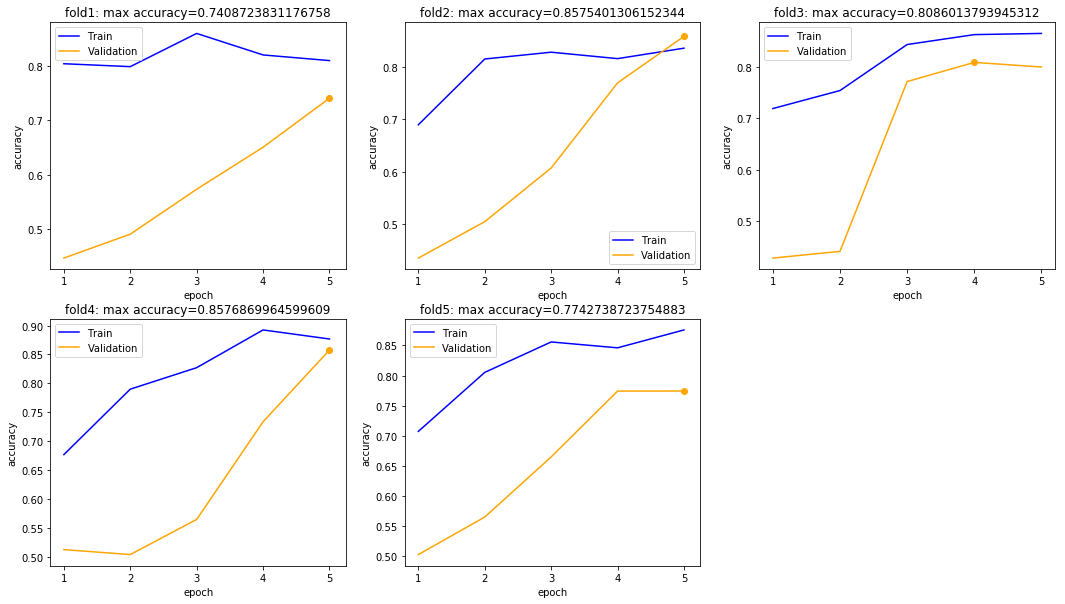

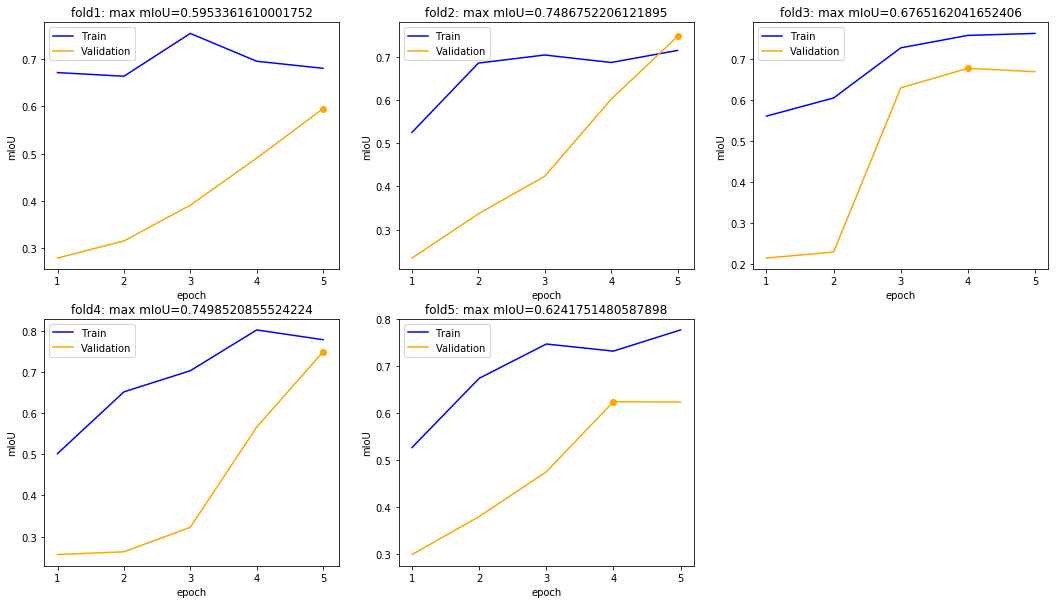

In [30]:
import os
import glob
import json
import matplotlib.pylab as plt

res_cv_path = glob.glob('results/result_seg_fold*')
res_log = []
for cv in res_cv_path:
    with open(os.path.join(cv, 'log'), 'r') as f:
        res_log.append(json.load(f))


%matplotlib inline
    
plt.figure(figsize=(18, 10))
for k in range(len(res_log)):
    train, val, epoch = [], [], []
    for n in range(len(res_log[k])):
        train.append(res_log[k][n]['main/accuracy'])
        val.append(res_log[k][n]['val/main/accuracy'])
        epoch.append(res_log[k][n]['epoch'])
    plt.subplot(2, 3, k+1)
    plt.plot(epoch, train, label='Train', color='blue')
    plt.plot(epoch, val, label='Validation', color='orange')
    plt.scatter(np.argmax(val)+1, np.max(val), marker='o', color='orange')
    plt.xticks(epoch)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('fold{}: max accuracy={}'.format(k+1, np.max(val)))
    plt.legend()
    
    
plt.figure(figsize=(18, 10))
for k in range(len(res_log)):
    train, val, epoch = [], [], []
    for n in range(len(res_log[k])):
        train.append(res_log[k][n]['main/miou'])
        val.append(res_log[k][n]['val/main/miou'])
        epoch.append(res_log[k][n]['epoch'])
    plt.subplot(2, 3, k+1)
    plt.plot(epoch, train, label='Train', color='blue')
    plt.plot(epoch, val, label='Validation', color='orange')
    plt.scatter(np.argmax(val)+1, np.max(val), marker='o', color='orange')
    plt.xticks(epoch)
    plt.xlabel('epoch')
    plt.ylabel('mIoU')
    plt.title('fold{}: max mIoU={}'.format(k+1, np.max(val)))
    plt.legend()

## テスト関数の作成

In [54]:
import numpy as np
import skimage.io as io
import chainer
from chainer import cuda
import chainer.functions as F
from chainer import serializers
from chainercv import evaluations

def test(root_path, test_path, model_path, out='results/result_seg_test', device=-1):
    test_dataset = SegmentationDataset(root_path, test_path)
    
    model = SegmentationModel(n_class=2)
    train_model = Classifier(model)
    serializers.load_npz(model_path, train_model)
    
    os.makedirs(out, exist_ok=True)
    accuracy, miou = 0, 0
    for i in range(test_dataset.__len__()):
        x, t = test_dataset.get_example(i)
        y = train_model.predict(np.expand_dims(x, axis=0))
        y = F.softmax(y).data
        y = np.array(y[:, 1, ...] > y[:, 0, ...], dtype=np.int32)
        t = np.expand_dims(t, axis=0)
        evals = evaluations.eval_semantic_segmentation(y, t)
        accuracy += evals['pixel_accuracy']
        miou += evals['miou']
        io.imsave(os.path.join(out, test_dataset.split_list[i]), np.array(y[0], dtype=np.uint8) * 255)
                
    with open(os.path.join(out, 'result.txt'), 'w') as f:
        f.write('accuracy: {}\n'.format(accuracy / test_dataset.__len__()))
        f.write('mIoU: {}\n'.format(miou/ test_dataset.__len__()))
    print('accuracy: {}'.format(accuracy / test_dataset.__len__()))
    print('mIoU: {}'.format(miou / test_dataset.__len__()))

## テスト

In [57]:
root_path = '../dataset_seg'
test_path = '../dataset_seg/split_list/test.txt'
model_path = 'results/result_seg/best_miou_model'

test(root_path, test_path, model_path, 'results/result_seg_test', device=-1)

accuracy: 0.6753285725911459
mIoU: 0.5495096036715629
